<a href="https://colab.research.google.com/github/Cr1mson901/IntroToPyTorch/blob/main/02_nnClassification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

## What is classification
Differentiating between 2 or more things, object identifier

* Binary classification - A or B
* Multiclass classification - A lot of classes
* Multilabel classification - Like youtube tags, one input can yield multiple outputs

## 1. Make classification data and get it ready

In [ ]:
import torch
from torch import nn
from sklearn.datasets import make_circles
import sklearn#scikitlearn

#Make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=.03,
                    random_state=42)



In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f'First 5 samples of X: {X[:5]}\n')
print(f'First 5 samples of y: {y[:5]}')


First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:,1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


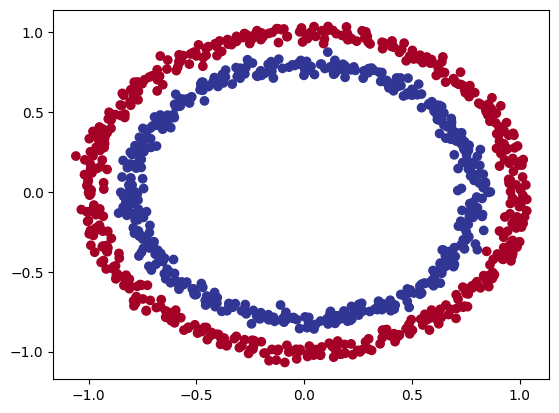

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment with but still sizeable enough to practice the fundamentals

### Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
X_sample.shape, y_sample.shape

((2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [ ]:
#Turn data into tensors
y = torch.from_numpy(y).type(torch.float)
X = torch.from_numpy(X).type(torch.float)


In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, #splits array into random splits
                                                    y,
                                                    test_size=0.2,#%20 percent of the data
                                                    random_state=42)#Random seed
len(X_train), len(X_test)


(800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing 'nn.Module')
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
#Device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Now we've setup device agnostic code, let's create a model that:
1. Sublass nn.Module
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a 'forward' method that outlines the forward pass(or forward computation)
4. Insatiate an instance of our model class and send it to the target device

In [ ]:
# 1. create model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)#Layer 1 leads into layer 2, more numbers more patterns, there is diminising return
    self.layer_2 = nn.Linear(in_features=5, out_features=1)#Layer 2 provides output
  #3. Define a forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))# x->layer_1->layer_2

#4. make a model class instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Let's replicate the model above using nn.Sequential, same as above
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2183,  0.1780],
                      [ 0.4126, -0.3846],
                      [ 0.3986, -0.6872],
                      [-0.4978, -0.6142],
                      [ 0.1230, -0.4843]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6190, -0.4472, -0.2608,  0.2050,  0.1454], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2617,  0.0160, -0.2345, -0.3256, -0.0652]], device='cuda:0')),
             ('1.bias', tensor([0.0807], device='cuda:0'))])

In [ ]:
#Make predictions
with torch.inference_mode():
  preds = torch.round(model_0(X_train.type(torch.float)))
preds[:10], y_train[:10]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

## 2.1 Setup loss function and optimizer
Which loss function or optimizer should you use?

Again.. this is problem specific

For example for regression you might want MAE or MSE(mean absolute error)

For classification you might want binary cross entropy or categorical cross entropy

For optimizers you can use Adam or SGD

In [ ]:
#Create loss function
#nn.BCELoss() needs to have been run through sigmoid activation first nn.sigmoid
loss_fn = nn.BCEWithLogitsLoss() #Has sigmoid activation function built in

#Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)#dont forget parenthases after parameters

In [ ]:

# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()#torch.eq(x,y) sees if x = y
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

Training loop
1. run through the code
2. get loss
3. set optimizer grad to zero
4. backward propegation
5. optimizer step


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can covert these logits into prediction probabilities by passing them to some kind of activation function(sigmoid for binary classification and softmax for multiclass classification)

The we can convert our model's prediction probabilities to prediction label by either round them or taking the argmax()

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logit = model_0(X_test.to(device))[:5]
y_logit

tensor([[ 0.5122],
        [ 0.6363],
        [ 0.0770],
        [ 0.6360],
        [-0.0977]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits
y_pred_prob = torch.sigmoid(y_logit)
y_pred_prob

tensor([[0.6253],
        [0.6539],
        [0.5192],
        [0.6539],
        [0.4756]], device='cuda:0')

For our prediction probability values, we need to perform a range-style round on them:
* 'y_pred_probs' >= .5, y=1(class 1)
* y_pred_probs < .5, y=0 (class 0)

In [ ]:
y_preds = torch.round(y_pred_prob)
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

## 3.2 Building a test loop

In [ ]:
torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
  #Loop
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  #Loss and accuracy
  loss = loss_fn(y_logits,
                 y_train)#Expects logits as input not Y_preds

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)
  #Grad 0
  optimizer.zero_grad()
  #Backpropegation
  loss.backward()
  #optimize
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn(test_logits, y_test)

  test_acc = accuracy_fn(y_true=y_test,
                         y_pred=test_preds)

  if epoch%100 == 0:
    print(f"Loss:{loss:.5f} | acc:{acc} | Test loss{test_loss:.5f} | test acc{test_acc}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

Lets make some predictions and visualize

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
  print('File exists')
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary


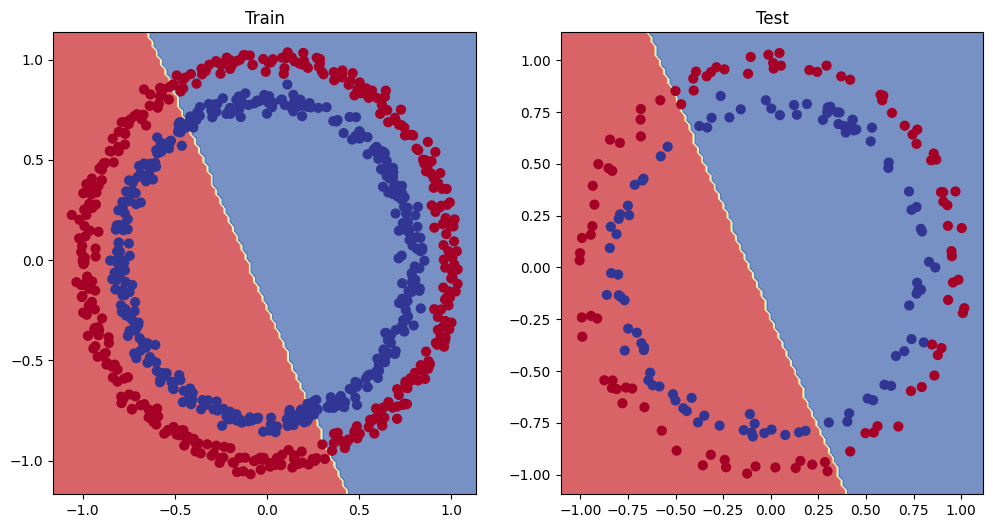

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model(from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data

* Add more hidden units - eg.go from 5 to 10
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the run through rate
* Change the loss function

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way leverages speed ups where possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
# Write loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr = .01)

In [ ]:
torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
  model_1.train()
  y_logit = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))

  loss = loss_fn(y_logit, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model_1.eval()
  with torch.inference_mode():
    test_logit = model_1(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logit))

  test_loss = loss_fn(test_logit, y_test)
  test_acc = accuracy_fn(y_test, test_pred)

  if epoch%100 == 0:
    print(f"Loss:{loss:.5f} | acc:{acc:.2f} | Test loss{test_loss:.5f} | test acc{test_acc:.2f}")


Loss:0.69864 | acc:47.62 | Test loss0.69400 | test acc51.00
Loss:0.69650 | acc:48.62 | Test loss0.69274 | test acc50.50
Loss:0.69559 | acc:49.62 | Test loss0.69246 | test acc51.00
Loss:0.69507 | acc:49.88 | Test loss0.69241 | test acc52.00
Loss:0.69471 | acc:49.62 | Test loss0.69242 | test acc50.50
Loss:0.69442 | acc:50.38 | Test loss0.69245 | test acc51.00
Loss:0.69420 | acc:50.38 | Test loss0.69249 | test acc50.00
Loss:0.69401 | acc:50.38 | Test loss0.69255 | test acc50.00
Loss:0.69385 | acc:50.25 | Test loss0.69261 | test acc50.00
Loss:0.69372 | acc:50.00 | Test loss0.69268 | test acc51.00


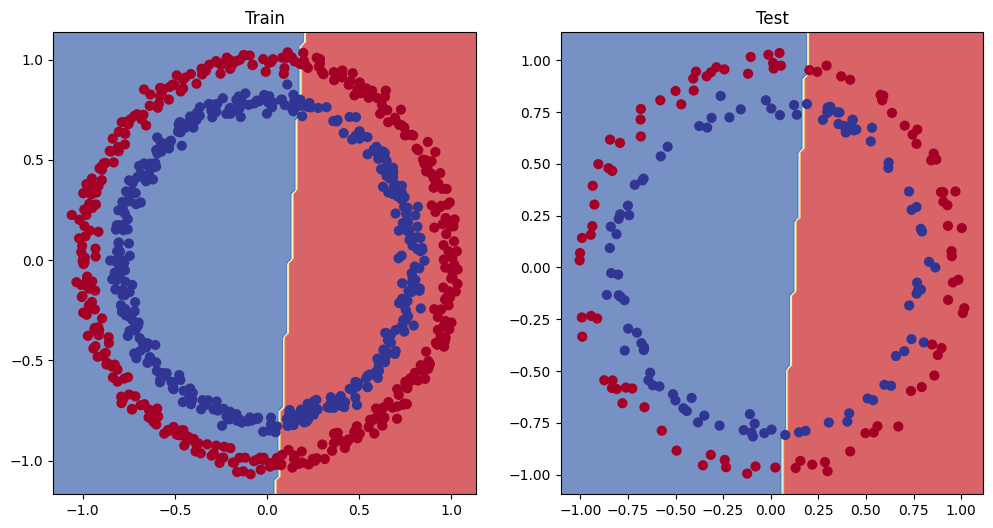

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
## 6. The missing piece: non-linearity

'What patterns can you draw with a near infinit amoutn of straight and curved lines'

'What patterns can you draw with a near infinit amoutn of straight and curved lines'

### 6.1 Recreating non-linear data (red and blue circles)

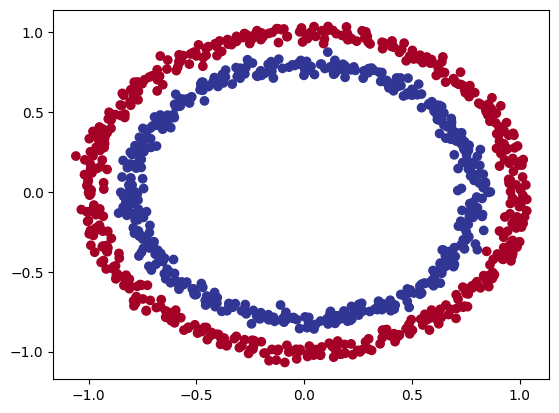

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=.03,
                    random_state=42)
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(8,8)
    self.layer_3 = nn.Linear(8,1)
    self.relu = nn.ReLU()#non linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=.1)

In [ ]:
torch.manual_seed(42)
epochs = 5000
for epoch in range(epochs):
  model_2.train()
  train_logits = model_2(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits))
  loss = loss_fn(train_logits, y_train)
  acc = accuracy_fn(y_train, train_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch%100 == 0:
    print(f"Loss:{loss:.5f} | acc:{acc:.2f} | Test loss{test_loss:.5f} | test acc{test_acc:.2f}")

Loss:0.69265 | acc:50.00 | Test loss0.69001 | test acc50.00
Loss:0.69042 | acc:50.75 | Test loss0.68767 | test acc56.00
Loss:0.68888 | acc:51.62 | Test loss0.68571 | test acc56.00
Loss:0.68685 | acc:52.00 | Test loss0.68324 | test acc55.50
Loss:0.68401 | acc:52.38 | Test loss0.68002 | test acc56.00
Loss:0.67967 | acc:54.12 | Test loss0.67542 | test acc56.50
Loss:0.67261 | acc:60.62 | Test loss0.66837 | test acc60.50
Loss:0.66090 | acc:72.12 | Test loss0.65786 | test acc74.00
Loss:0.63953 | acc:77.50 | Test loss0.64090 | test acc80.50
Loss:0.59743 | acc:87.88 | Test loss0.60612 | test acc88.00
Loss:0.51989 | acc:94.00 | Test loss0.53833 | test acc90.50
Loss:0.40137 | acc:96.50 | Test loss0.43150 | test acc94.50
Loss:0.26575 | acc:98.88 | Test loss0.30320 | test acc97.00
Loss:0.16836 | acc:99.38 | Test loss0.20610 | test acc98.00
Loss:0.11849 | acc:99.62 | Test loss0.15272 | test acc98.50
Loss:0.08196 | acc:99.88 | Test loss0.11475 | test acc98.50
Loss:0.06075 | acc:99.88 | Test loss0.09

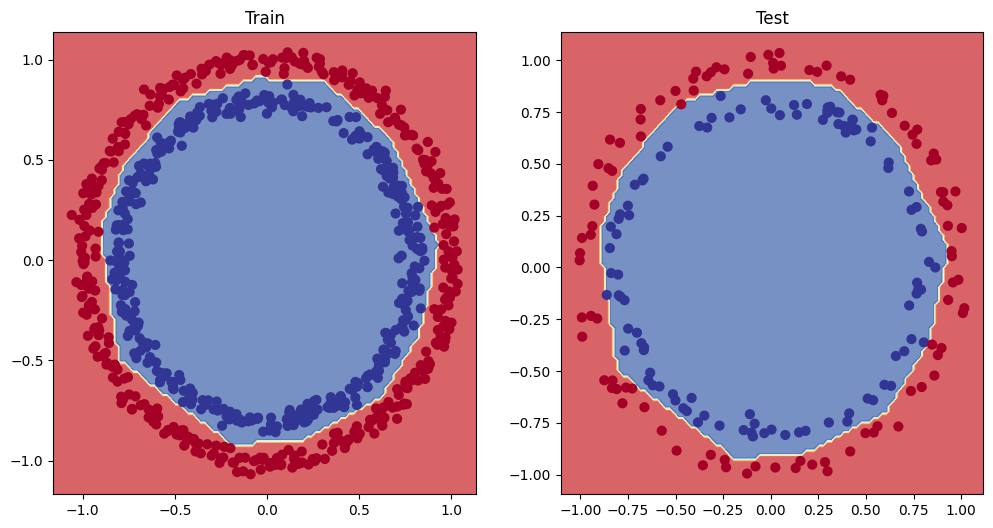

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

## 8. Putting it all together with a multi-class classification problem

* Binary classification = A or B

* More than one thing or another

## 8.1 Creating a toy multi-class dataset

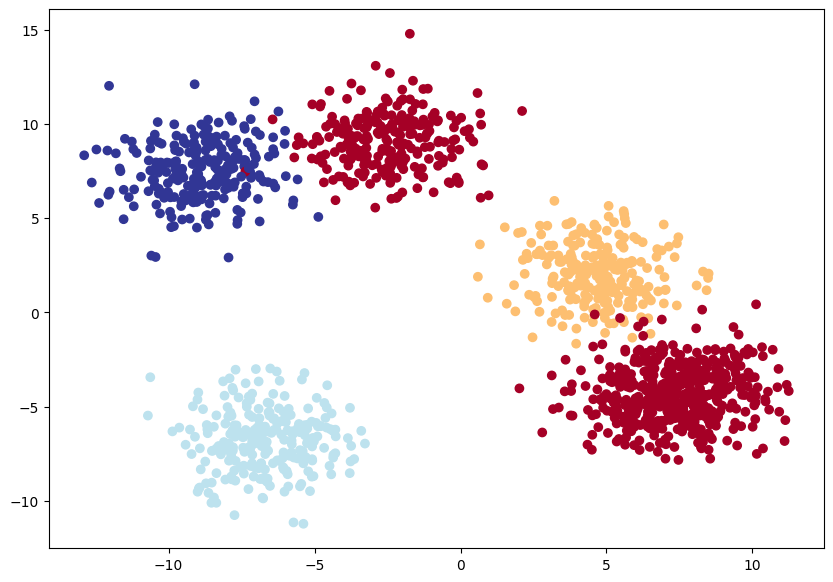

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create multi class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

X_blob1,y_blob1 = make_blobs(n_samples=500,
                           n_features=NUM_FEATURES,
                           centers=1,
                           cluster_std=1.5,
                            random_state=29)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob1 = torch.from_numpy(X_blob1).type(torch.float)
y_blob1 = torch.from_numpy(y_blob1).type(torch.LongTensor)

X_blob = torch.vstack((X_blob, X_blob1))
y_blob = torch.hstack((y_blob, y_blob1))

X_blob.shape, y_blob.shape
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=.2,
                                                                        random_state=RANDOM_SEED
                                                                        )
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
X_blob_train.shape

torch.Size([1200, 2])

## 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(2,4).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=.1)


## 8.4 Creating a test loop

In order to evaluate you must convert your logits to prediction probabilities and prediction labels

In [ ]:
#Building a training loop
epochs = 1000
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  train_logits = model_4(X_blob_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
  loss = loss_fn(train_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, train_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  if epoch%100 == 0:
    print(f"Loss:{loss:.5f} | acc:{acc:.2f} | Test loss{test_loss:.5f} | test acc{test_acc:.2f}")


Loss:1.56912 | acc:36.17 | Test loss1.43198 | test acc43.00
Loss:0.08418 | acc:97.58 | Test loss0.09744 | test acc96.67
Loss:0.05711 | acc:98.08 | Test loss0.06755 | test acc97.67
Loss:0.05074 | acc:98.25 | Test loss0.05838 | test acc97.67
Loss:0.04684 | acc:98.42 | Test loss0.05242 | test acc98.00
Loss:0.04371 | acc:98.42 | Test loss0.04776 | test acc98.33
Loss:0.04114 | acc:98.50 | Test loss0.04395 | test acc98.67
Loss:0.03896 | acc:98.50 | Test loss0.04083 | test acc99.00
Loss:0.03708 | acc:98.58 | Test loss0.03820 | test acc99.00
Loss:0.03543 | acc:98.58 | Test loss0.03601 | test acc99.00


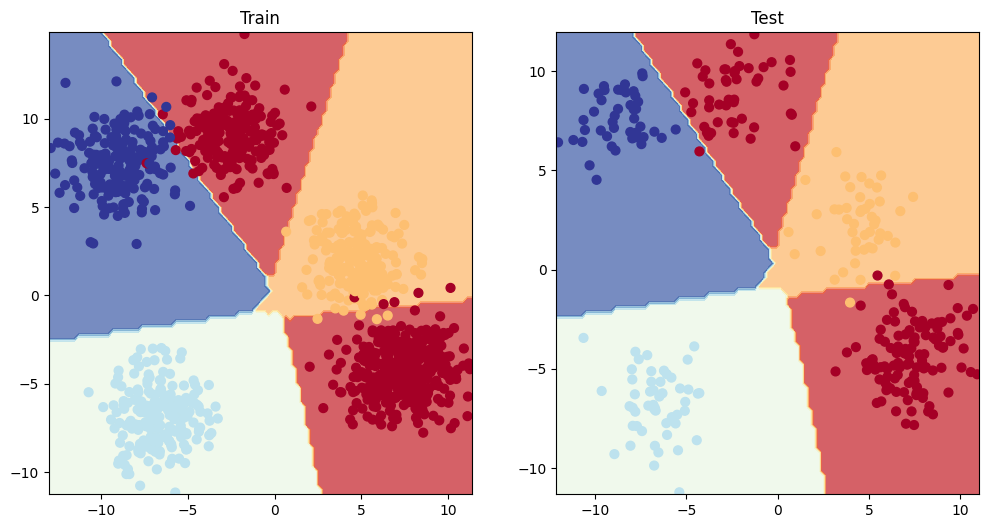

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
  print('File exists')
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


## 9. A few mor classification metrics..(to evaluate a classifictin model)

* Accuracy - %Correct - torchmetrics.Accuracy()
* Precision - torchmetrics.precision()
* Recall - torchmetrics.Recall()
* F1-score - torchmetrics.F1Score()
* Confusion matrix -
* Classification report